In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf
import sys
sys.path.append("..")
from sleeprnn.nn import wave_augment
from sleeprnn.helpers import reader, plotter
from sleeprnn.data import utils
from sleeprnn.common import viz, constants, pkeys

viz.notebook_full_width()

In [2]:
def extract_amplitudes(signal, marks, band, filter_amplitudes_less_than=10, fs=200, border_size=1000):
    band_signal = utils.apply_bandpass(signal, fs, band[0], band[1])
    band_signal = band_signal[:, border_size:-border_size]
    band_amplitude = np.abs(scipy.signal.hilbert(band_signal))
    amp_background_list = []
    amp_event_list = []
    for page_mark, page_amplitude in zip(marks, band_amplitude):
        amp_background = page_amplitude[page_mark == 0].max()
        amp_background_list.append(amp_background)
        if page_mark.sum() > 0:
            amp_event = page_amplitude[page_mark == 1].max()
            amp_event_list.append(amp_event)
    band_amplitude_background = np.array(amp_background_list)
    band_amplitude_event = np.array(amp_event_list)
    # band_amplitude_background = band_amplitude_vector[marks_vector==0]
    # band_amplitude_event = band_amplitude_vector[marks_vector==1]
    # band_amplitude_background = band_amplitude_background[band_amplitude_background >= filter_amplitudes_less_than]
    # band_amplitude_event = band_amplitude_event[band_amplitude_event >= filter_amplitudes_less_than]
    return band_amplitude_background, band_amplitude_event

# Band amplitudes --- E1-SS

In [4]:
mass = reader.load_dataset(constants.MASS_SS_NAME, load_checkpoint=True, verbose=False)
which_expert = 1

In [4]:
bins = np.arange(0, 50 + 1e-3, 1)
border_size = 1000
bands = [
    (None, 2),
    (2, 4),
    (4, 8),
    (7, 10),
    (11, 16)
]
x_l = []
y_outside_l = {band: [] for band in bands}
y_inside_l = {band: [] for band in bands}
for subject_id in mass.train_ids:
    print("Subject ID %s" % subject_id)
    signal, marks = mass.get_subject_data(subject_id, normalize_clip=False, which_expert=which_expert, border_size=border_size)
    marks = marks[:, border_size:-border_size]
    for i, band in enumerate(bands):
        amp_outside, amp_inside = extract_amplitudes(signal, marks, band)
        # outside plot
        counts_outside, _ = np.histogram(amp_outside, bins=bins, density=True)
        x, y_outside = plotter.piecewise_constant_histogram(bins, counts_outside)
        # inside plot
        counts_inside, _ = np.histogram(amp_inside, bins=bins, density=True)
        _, y_inside = plotter.piecewise_constant_histogram(bins, counts_inside)
        x_l.append(x)
        y_outside_l[band].append(y_outside)
        y_inside_l[band].append(y_inside)
x_l = np.stack(x_l, axis=0).mean(axis=0)
for band in bands:
    y_outside_l[band] = np.stack(y_outside_l[band], axis=0).mean(axis=0)
    y_inside_l[band] = np.stack(y_inside_l[band], axis=0).mean(axis=0)
    
ss_x_l = x_l
ss_y_outside_l = y_outside_l
ss_y_inside_l = y_inside_l

Subject ID 1


/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


Subject ID 3
Subject ID 5
Subject ID 7
Subject ID 9
Subject ID 10
Subject ID 11
Subject ID 14
Subject ID 17
Subject ID 18
Subject ID 19


In [5]:
def find_mass_thr(curve, mass_thr):
    cum_inside = np.cumsum(curve) / np.sum(curve)
    thr_point = np.argmin((cum_inside - mass_thr) ** 2)
    return thr_point

Band None-2 Hz: Proba thr 0.5: 18 uV inside,  30 uV outside
Band 2-4 Hz: Proba thr 0.5: 13 uV inside,  23 uV outside
Band 4-8 Hz: Proba thr 0.5: 11 uV inside,  20 uV outside
Band 7-10 Hz: Proba thr 0.5: 6 uV inside,  12 uV outside
Band 11-16 Hz: Proba thr 0.5: 20 uV inside,  14 uV outside


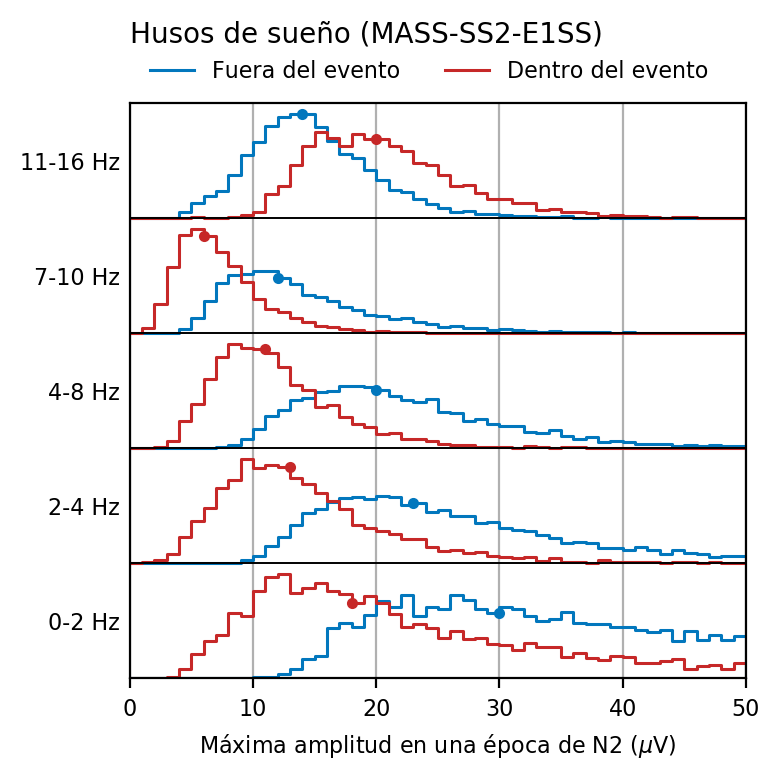

In [6]:
proba_thr = 0.5
title_str = "Husos de sueño (MASS-SS2-E1SS)"
hist_args = dict(bins=bins, histtype='step', density=True)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
label_shown = False
for i, band in enumerate(bands):
    x_inside = x_l
    x_outside = x_l
    y_inside = y_inside_l[band]
    loc_thr_inside = find_mass_thr(y_inside, proba_thr)
    y_outside = y_outside_l[band]
    loc_thr_outside = find_mass_thr(y_outside, proba_thr)
    # Norm
    max_y = max(y_outside.max(), y_inside.max())
    y_outside = y_outside / (1.1 * max_y)
    y_inside = y_inside / (1.1 * max_y)
    # Offset
    y_outside += i
    y_inside += i
    label_outside = None if label_shown else "Fuera del evento"
    label_inside = None if label_shown else "Dentro del evento"
    label_shown = True
    ax.plot(x_outside, y_outside, color=viz.PALETTE['blue'], linewidth=1.1, label=label_outside)
    ax.plot(x_inside, y_inside, color=viz.PALETTE['red'], linewidth=1.1, label=label_inside)
    ax.plot(x_outside[loc_thr_outside], y_outside[loc_thr_outside], marker='o', markersize=3, color=viz.PALETTE['blue'])
    ax.plot(x_inside[loc_thr_inside], y_inside[loc_thr_inside], marker='o', markersize=3, color=viz.PALETTE['red'])
    ax.axhline(i, color='k', linewidth=0.7)
    print("Band %s-%s Hz:" % band, "Proba thr %s: %d uV inside,  %d uV outside" % (proba_thr, x_inside[loc_thr_inside], x_outside[loc_thr_outside]))
bands_for_ticks = [(0 if band[0] is None else band[0], band[1]) for band in bands]
ax.set_yticks(0.5 + np.arange(len(bands)))
ax.set_yticklabels(['%s-%s Hz' % band for band in bands_for_ticks])
ax.tick_params(labelsize=8)
ax.tick_params(axis='y', which='both', length=0)
ax.set_ylim([0, len(bands)])
ax.set_xlabel("Máxima amplitud en una época de N2 ($\mu$V)", fontsize=8)
ax.set_xlim([x_l.min(), x_l.max()])
ax.legend(fontsize=8, loc="lower left", bbox_to_anchor=(0, 1), ncol=2, frameon=False)
ax.grid(axis="x")
ax.set_title(title_str, fontsize=10, loc="left", pad=22)
plt.tight_layout()
plt.show()

# Band amplitudes --- KC

In [7]:
mass = reader.load_dataset(constants.MASS_KC_NAME, load_checkpoint=True, verbose=False)
which_expert = 1

In [8]:
bins = np.arange(0, 50 + 1e-3, 1)
border_size = 1000
bands = [
    (None, 2),
    (2, 4),
    (4, 8),
    (7, 10),
    (11, 16)
]
x_l = []
y_outside_l = {band: [] for band in bands}
y_inside_l = {band: [] for band in bands}
for subject_id in mass.train_ids:
    print("Subject ID %s" % subject_id)
    signal, marks = mass.get_subject_data(subject_id, normalize_clip=False, which_expert=which_expert, border_size=border_size)
    marks = marks[:, border_size:-border_size]
    for i, band in enumerate(bands):
        amp_outside, amp_inside = extract_amplitudes(signal, marks, band)
        # outside plot
        counts_outside, _ = np.histogram(amp_outside, bins=bins, density=True)
        x, y_outside = plotter.piecewise_constant_histogram(bins, counts_outside)
        # inside plot
        counts_inside, _ = np.histogram(amp_inside, bins=bins, density=True)
        _, y_inside = plotter.piecewise_constant_histogram(bins, counts_inside)
        x_l.append(x)
        y_outside_l[band].append(y_outside)
        y_inside_l[band].append(y_inside)
x_l = np.stack(x_l, axis=0).mean(axis=0)
for band in bands:
    y_outside_l[band] = np.stack(y_outside_l[band], axis=0).mean(axis=0)
    y_inside_l[band] = np.stack(y_inside_l[band], axis=0).mean(axis=0)
kc_x_l = x_l
kc_y_outside_l = y_outside_l
kc_y_inside_l = y_inside_l

Subject ID 1
Subject ID 3
Subject ID 5
Subject ID 7
Subject ID 9
Subject ID 10
Subject ID 11
Subject ID 14
Subject ID 17
Subject ID 18
Subject ID 19


Band None-2 Hz: Proba thr 0.5: 40 uV inside,  32 uV outside
Band 2-4 Hz: Proba thr 0.5: 25 uV inside,  22 uV outside
Band 4-8 Hz: Proba thr 0.5: 19 uV inside,  20 uV outside
Band 7-10 Hz: Proba thr 0.5: 11 uV inside,  12 uV outside
Band 11-16 Hz: Proba thr 0.5: 10 uV inside,  17 uV outside


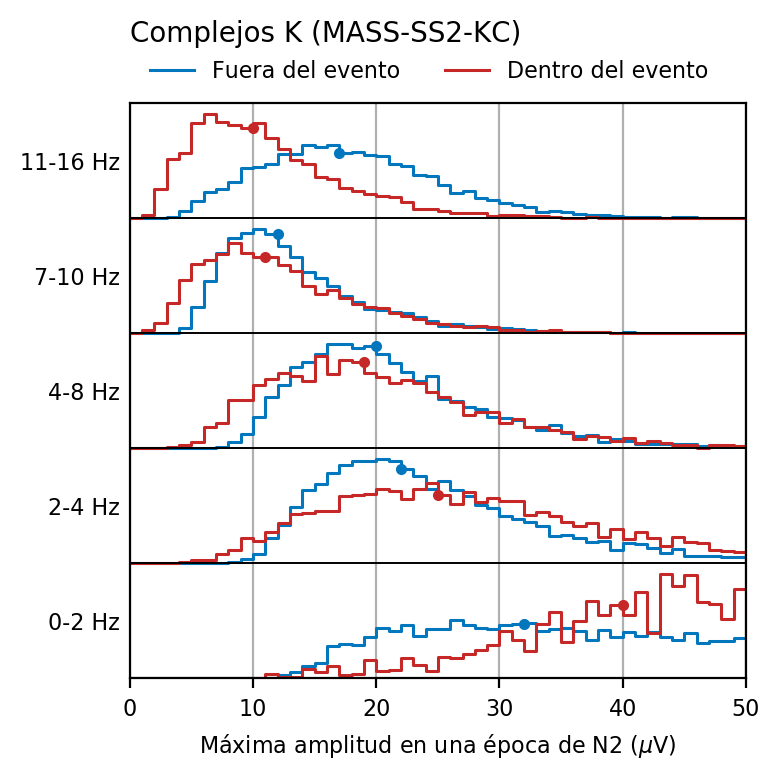

In [9]:
title_str = "Complejos K (MASS-SS2-KC)"
hist_args = dict(bins=bins, histtype='step', density=True)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
label_shown = False
for i, band in enumerate(bands):
    x_inside = x_l
    x_outside = x_l
    y_inside = y_inside_l[band]
    loc_thr_inside = find_mass_thr(y_inside, proba_thr)
    y_outside = y_outside_l[band]
    loc_thr_outside = find_mass_thr(y_outside, proba_thr)
    # Norm
    max_y = max(y_outside.max(), y_inside.max())
    y_outside = y_outside / (1.1 * max_y)
    y_inside = y_inside / (1.1 * max_y)
    # Offset
    y_outside += i
    y_inside += i
    label_outside = None if label_shown else "Fuera del evento"
    label_inside = None if label_shown else "Dentro del evento"
    label_shown = True
    ax.plot(x_outside, y_outside, color=viz.PALETTE['blue'], linewidth=1.1, label=label_outside)
    ax.plot(x_inside, y_inside, color=viz.PALETTE['red'], linewidth=1.1, label=label_inside)
    ax.plot(x_outside[loc_thr_outside], y_outside[loc_thr_outside], marker='o', markersize=3, color=viz.PALETTE['blue'])
    ax.plot(x_inside[loc_thr_inside], y_inside[loc_thr_inside], marker='o', markersize=3, color=viz.PALETTE['red'])
    ax.axhline(i, color='k', linewidth=0.7)
    print("Band %s-%s Hz:" % band, "Proba thr %s: %d uV inside,  %d uV outside" % (proba_thr, x_inside[loc_thr_inside], x_outside[loc_thr_outside]))
bands_for_ticks = [(0 if band[0] is None else band[0], band[1]) for band in bands]
ax.set_yticks(0.5 + np.arange(len(bands)))
ax.set_yticklabels(['%s-%s Hz' % band for band in bands_for_ticks])
ax.tick_params(labelsize=8)
ax.tick_params(axis='y', which='both', length=0)
ax.set_ylim([0, len(bands)])
ax.set_xlabel("Máxima amplitud en una época de N2 ($\mu$V)", fontsize=8)
ax.set_xlim([x_l.min(), x_l.max()])
ax.legend(fontsize=8, loc="lower left", bbox_to_anchor=(0, 1), ncol=2, frameon=False)
ax.grid(axis="x")
ax.set_title(title_str, fontsize=10, loc="left", pad=22)
plt.tight_layout()
plt.show()

# Unified graph

Band None-2 Hz: Proba thr 0.5: 18 uV inside,  30 uV outside
Band 2-4 Hz: Proba thr 0.5: 13 uV inside,  23 uV outside
Band 4-8 Hz: Proba thr 0.5: 11 uV inside,  20 uV outside
Band 7-10 Hz: Proba thr 0.5: 6 uV inside,  12 uV outside
Band 11-16 Hz: Proba thr 0.5: 20 uV inside,  14 uV outside
Band None-2 Hz: Proba thr 0.5: 40 uV inside,  32 uV outside
Band 2-4 Hz: Proba thr 0.5: 25 uV inside,  22 uV outside
Band 4-8 Hz: Proba thr 0.5: 19 uV inside,  20 uV outside
Band 7-10 Hz: Proba thr 0.5: 11 uV inside,  12 uV outside
Band 11-16 Hz: Proba thr 0.5: 10 uV inside,  17 uV outside


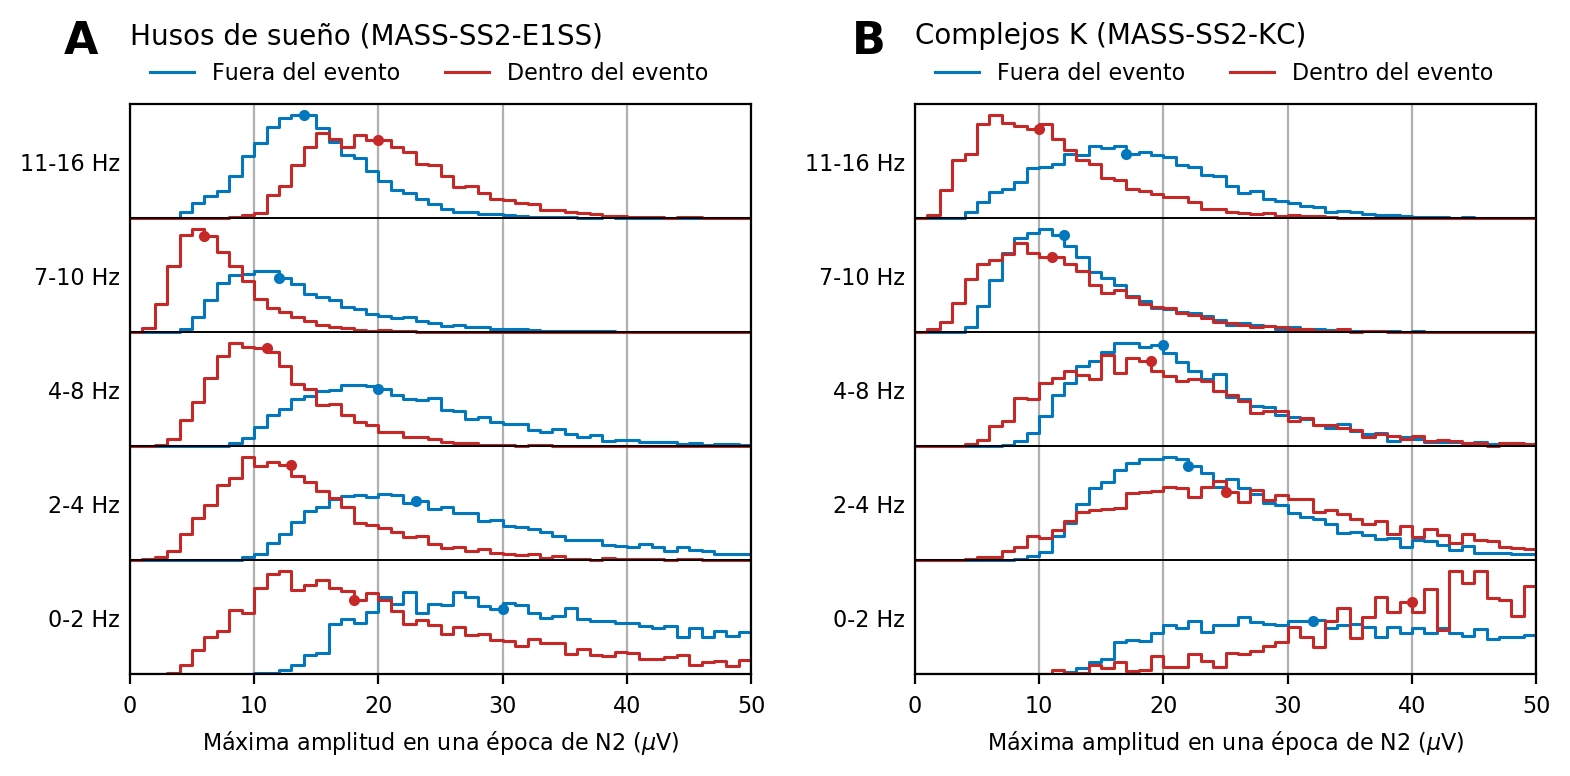

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200)

ax = axes[0]
x_l = ss_x_l
y_outside_l = ss_y_outside_l
y_inside_l = ss_y_inside_l

title_str = "Husos de sueño (MASS-SS2-E1SS)"
hist_args = dict(bins=bins, histtype='step', density=True)
label_shown = False
for i, band in enumerate(bands):
    x_inside = x_l
    x_outside = x_l
    y_inside = y_inside_l[band]
    loc_thr_inside = find_mass_thr(y_inside, proba_thr)
    y_outside = y_outside_l[band]
    loc_thr_outside = find_mass_thr(y_outside, proba_thr)
    # Norm
    max_y = max(y_outside.max(), y_inside.max())
    y_outside = y_outside / (1.1 * max_y)
    y_inside = y_inside / (1.1 * max_y)
    # Offset
    y_outside += i
    y_inside += i
    label_outside = None if label_shown else "Fuera del evento"
    label_inside = None if label_shown else "Dentro del evento"
    label_shown = True
    ax.plot(x_outside, y_outside, color=viz.PALETTE['blue'], linewidth=1.1, label=label_outside)
    ax.plot(x_inside, y_inside, color=viz.PALETTE['red'], linewidth=1.1, label=label_inside)
    ax.plot(x_outside[loc_thr_outside], y_outside[loc_thr_outside], marker='o', markersize=3, color=viz.PALETTE['blue'])
    ax.plot(x_inside[loc_thr_inside], y_inside[loc_thr_inside], marker='o', markersize=3, color=viz.PALETTE['red'])
    ax.axhline(i, color='k', linewidth=0.7)
    print("Band %s-%s Hz:" % band, "Proba thr %s: %d uV inside,  %d uV outside" % (proba_thr, x_inside[loc_thr_inside], x_outside[loc_thr_outside]))
bands_for_ticks = [(0 if band[0] is None else band[0], band[1]) for band in bands]
ax.set_yticks(0.5 + np.arange(len(bands)))
ax.set_yticklabels(['%s-%s Hz' % band for band in bands_for_ticks])
ax.tick_params(labelsize=8)
ax.tick_params(axis='y', which='both', length=0)
ax.set_ylim([0, len(bands)])
ax.set_xlabel("Máxima amplitud en una época de N2 ($\mu$V)", fontsize=8)
ax.set_xlim([x_l.min(), x_l.max()])
ax.legend(fontsize=8, loc="lower left", bbox_to_anchor=(0, 1), ncol=2, frameon=False)
ax.grid(axis="x")
ax.set_title(title_str, fontsize=10, loc="left", pad=22)

ax.text(
    x=-0.05, y=1.09, fontsize=16, 
    s=r"$\bf{A}$", 
    ha="right", transform=ax.transAxes)


ax = axes[1]
x_l = kc_x_l
y_outside_l = kc_y_outside_l
y_inside_l = kc_y_inside_l

title_str = "Complejos K (MASS-SS2-KC)"
hist_args = dict(bins=bins, histtype='step', density=True)
label_shown = False
for i, band in enumerate(bands):
    x_inside = x_l
    x_outside = x_l
    y_inside = y_inside_l[band]
    loc_thr_inside = find_mass_thr(y_inside, proba_thr)
    y_outside = y_outside_l[band]
    loc_thr_outside = find_mass_thr(y_outside, proba_thr)
    # Norm
    max_y = max(y_outside.max(), y_inside.max())
    y_outside = y_outside / (1.1 * max_y)
    y_inside = y_inside / (1.1 * max_y)
    # Offset
    y_outside += i
    y_inside += i
    label_outside = None if label_shown else "Fuera del evento"
    label_inside = None if label_shown else "Dentro del evento"
    label_shown = True
    ax.plot(x_outside, y_outside, color=viz.PALETTE['blue'], linewidth=1.1, label=label_outside)
    ax.plot(x_inside, y_inside, color=viz.PALETTE['red'], linewidth=1.1, label=label_inside)
    ax.plot(x_outside[loc_thr_outside], y_outside[loc_thr_outside], marker='o', markersize=3, color=viz.PALETTE['blue'])
    ax.plot(x_inside[loc_thr_inside], y_inside[loc_thr_inside], marker='o', markersize=3, color=viz.PALETTE['red'])
    ax.axhline(i, color='k', linewidth=0.7)
    print("Band %s-%s Hz:" % band, "Proba thr %s: %d uV inside,  %d uV outside" % (proba_thr, x_inside[loc_thr_inside], x_outside[loc_thr_outside]))
bands_for_ticks = [(0 if band[0] is None else band[0], band[1]) for band in bands]
ax.set_yticks(0.5 + np.arange(len(bands)))
ax.set_yticklabels(['%s-%s Hz' % band for band in bands_for_ticks])
ax.tick_params(labelsize=8)
ax.tick_params(axis='y', which='both', length=0)
ax.set_ylim([0, len(bands)])
ax.set_xlabel("Máxima amplitud en una época de N2 ($\mu$V)", fontsize=8)
ax.set_xlim([x_l.min(), x_l.max()])
ax.legend(fontsize=8, loc="lower left", bbox_to_anchor=(0, 1), ncol=2, frameon=False)
ax.grid(axis="x")
ax.set_title(title_str, fontsize=10, loc="left", pad=22)

ax.text(
    x=-0.05, y=1.09, fontsize=16, 
    s=r"$\bf{B}$", 
    ha="right", transform=ax.transAxes)

plt.tight_layout()
# plt.savefig("data_augment_max_amp_stats.pdf", bbox_inches="tight", pad_inches=0.5)
# plt.savefig("data_augment_max_amp_stats.png", bbox_inches="tight", pad_inches=0.5)
# plt.savefig("data_augment_max_amp_stats.svg", bbox_inches="tight", pad_inches=0.5)
plt.show()

# Fig example data augment

In [101]:
def get_random_wave_result(feat, label, fs, params):
    tf.reset_default_graph()
    mask_keep_events = wave_augment.generate_soft_mask_from_labels_tf(label, fs, use_background=False)
    mask_keep_background = 1.0 - mask_keep_events
    mask_map_dict = {
        constants.MASK_KEEP_EVENTS: mask_keep_events,
        constants.MASK_KEEP_BACKGROUND: mask_keep_background,
        constants.MASK_NONE: None,
    }
    my_params = params.copy()
    my_params["mask"] = mask_map_dict[params["mask"]]
    feat_size = feat.size
    random_wave, intermediate_steps = wave_augment.generate_wave_tf(
        feat_size, fs, return_intermediate_steps=True, **my_params)
    intermediate_steps['generated_wave'] = random_wave
    with tf.Session() as sess:
        np_intermediate_steps = sess.run(intermediate_steps)
    return np_intermediate_steps


def get_random_anti_wave_result(feat, label, fs, params):
    tf.reset_default_graph()
    mask_keep_events = wave_augment.generate_soft_mask_from_labels_tf(label, fs, use_background=False)
    mask_keep_background = 1.0 - mask_keep_events
    mask_map_dict = {
        constants.MASK_KEEP_EVENTS: mask_keep_events,
        constants.MASK_KEEP_BACKGROUND: mask_keep_background,
        constants.MASK_NONE: None,
    }
    my_params = params.copy()
    my_params["mask"] = mask_map_dict[params["mask"]]
    feat_size = feat.size
    random_wave, intermediate_steps = wave_augment.generate_anti_wave_tf(
        feat, feat_size, fs, return_intermediate_steps=True, **my_params)
    intermediate_steps['generated_wave'] = random_wave
    with tf.Session() as sess:
        np_intermediate_steps = sess.run(intermediate_steps)
    return np_intermediate_steps

In [12]:
random_wave_params = dict(
        min_frequency=4, max_frequency=8, frequency_bandwidth=2, max_amplitude_microvolts=20,
        min_duration=1, max_duration=5, mask=constants.MASK_KEEP_BACKGROUND)
random_antiwave_params = dict(
        lowcut=4, highcut=8, max_attenuation=1,
        min_duration=1, max_duration=5, mask=constants.MASK_KEEP_EVENTS)
random_wave_params['max_amplitude'] = random_wave_params['max_amplitude_microvolts']  # For the example we are not normalizing
random_wave_params.pop('max_amplitude_microvolts');

In [5]:
mass = reader.load_dataset(constants.MASS_SS_NAME, load_checkpoint=True, verbose=False)
fs = mass.fs

In [74]:
signal = mass.get_subject_signal(1, normalize_clip=False, which_expert=1)
marks = mass.get_subject_stamps(1, which_expert=1)
marks = utils.stamp2seq(marks, start=0, end=signal.size-1)
start_sample = 2545900
end_sample = 2549900
start_sample = start_sample + 10 * fs
feat = signal[start_sample:end_sample]
label = marks[start_sample:end_sample]

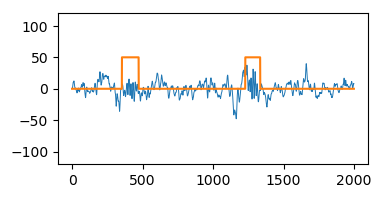

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2), dpi=100)
ax.plot(feat, linewidth=0.7)
ax.plot(label*50)
ax.set_ylim([-120, 120])
plt.show()

In [149]:
wave_results = get_random_wave_result(feat, label, fs, random_wave_params)

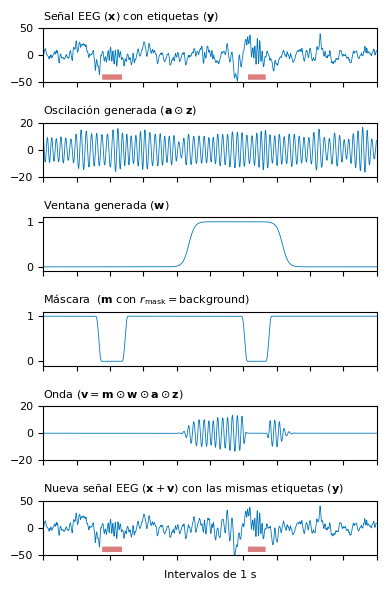

In [150]:
plot_args = dict(linewidth=0.6, color=viz.PALETTE['blue'])
time_axis = np.arange(feat.size) / fs

fig, axes = plt.subplots(6, 1, figsize=(4, 6), sharex=True, dpi=100)

def plot_wave_in_axes(axes):
    ax = axes[0]
    ax.set_title("Señal EEG ($\mathbf{x}$) con etiquetas ($\mathbf{y}$)", fontsize=8, loc="left")
    ax.plot(time_axis, feat, **plot_args)
    ax.fill_between(time_axis, -45, -45 + 10 * label, alpha=.6, facecolor=viz.PALETTE['red'])
    max_y = 50
    ax.set_ylim([-max_y, max_y])
    ax.set_xlim([time_axis[0], time_axis[-1]])

    ax = axes[1]
    ax.set_title("Oscilación generada ($\mathbf{a}\odot \mathbf{z}$)", fontsize=8, loc="left")
    ax.plot(time_axis, wave_results['oscillation'] * wave_results['amplitude'], **plot_args)
    max_y = np.ceil(wave_results['amplitude'].max() / 5) * 5
    ax.set_ylim([-max_y, max_y])

    ax = axes[2]
    ax.set_title("Ventana generada ($\mathbf{w}$)", fontsize=8, loc="left")
    ax.plot(time_axis, wave_results['window'], **plot_args)
    ax.set_ylim([-0.1, 1.1])

    ax = axes[3]
    ax.set_title("Máscara  ($\mathbf{m}$ con $r_\mathrm{mask}=\mathrm{background}$)", fontsize=8, loc="left")
    ax.plot(time_axis, wave_results['mask'], **plot_args)
    ax.set_ylim([-0.1, 1.1])

    ax = axes[4]
    ax.set_title("Onda ($\mathbf{v}=\mathbf{m}\odot \mathbf{w}\odot \mathbf{a}\odot \mathbf{z}$)", fontsize=8, loc="left")
    ax.plot(time_axis, wave_results['generated_wave'], **plot_args)
    max_y = np.ceil(wave_results['amplitude'].max() / 5) * 5
    ax.set_ylim([-max_y, max_y])

    ax = axes[5]
    ax.set_title("Nueva señal EEG ($\mathbf{x} + \mathbf{v}$) con las mismas etiquetas ($\mathbf{y}$)", fontsize=8, loc="left")
    ax.plot(time_axis, feat + wave_results['generated_wave'], **plot_args)
    ax.fill_between(time_axis, -45, -45 + 10 * label, alpha=.6, facecolor=viz.PALETTE['red'])
    max_y = 50
    ax.set_ylim([-max_y, max_y])

    axes[-1].set_xticks(np.arange(11))
    axes[-1].set_xticklabels([])
    axes[-1].set_xlabel("Intervalos de 1 s", fontsize=8)
    for ax in axes.flatten():
        ax.tick_params(labelsize=8)
        
plot_wave_in_axes(axes)
plt.tight_layout()
plt.show()

In [160]:
antiwave_results = get_random_anti_wave_result(feat, label, fs, random_antiwave_params)

In [ ]:
antiwave_results_bkp = antiwave_results

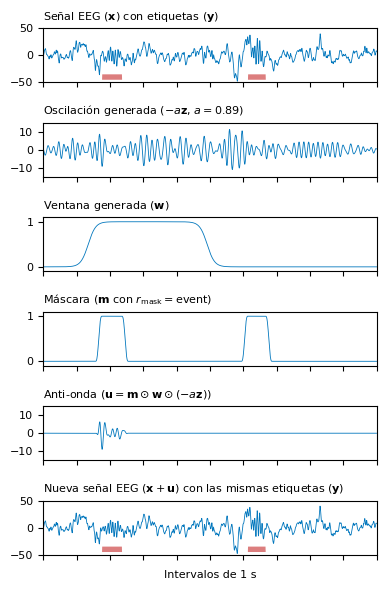

In [161]:
plot_args = dict(linewidth=0.6, color=viz.PALETTE['blue'])
time_axis = np.arange(feat.size) / fs

fig, axes = plt.subplots(6, 1, figsize=(4, 6), sharex=True, dpi=100)

def plot_antiwave_in_axes(axes):
    ax = axes[0]
    ax.set_title("Señal EEG ($\mathbf{x}$) con etiquetas ($\mathbf{y}$)", fontsize=8, loc="left")
    ax.plot(time_axis, feat, **plot_args)
    ax.fill_between(time_axis, -45, -45 + 10 * label, alpha=.6, facecolor=viz.PALETTE['red'])
    max_y = 50
    ax.set_ylim([-max_y, max_y])
    ax.set_xlim([time_axis[0], time_axis[-1]])

    ax = axes[1]
    ax.set_title("Oscilación generada ($-a\mathbf{z}$, $a=$%1.2f)" % (-antiwave_results['attenuation']), fontsize=8, loc="left")
    ax.plot(time_axis, antiwave_results['oscillation'] * antiwave_results['attenuation'], **plot_args)
    max_y = np.ceil(np.abs(antiwave_results['oscillation'] * antiwave_results['attenuation']).max() / 5) * 5
    ax.set_ylim([-max_y, max_y])

    ax = axes[2]
    ax.set_title("Ventana generada ($\mathbf{w}$)", fontsize=8, loc="left")
    ax.plot(time_axis, antiwave_results['window'], **plot_args)
    ax.set_ylim([-0.1, 1.1])

    ax = axes[3]
    ax.set_title("Máscara ($\mathbf{m}$ con $r_\mathrm{mask}=\mathrm{event}$)", fontsize=8, loc="left")
    ax.plot(time_axis, antiwave_results['mask'], **plot_args)
    ax.set_ylim([-0.1, 1.1])

    ax = axes[4]
    ax.set_title("Anti-onda ($\mathbf{u}=\mathbf{m}\odot \mathbf{w}\odot (-a\mathbf{z})$)", fontsize=8, loc="left")
    ax.plot(time_axis, antiwave_results['generated_wave'], **plot_args)
    max_y = np.ceil(np.abs(antiwave_results['oscillation'] * antiwave_results['attenuation']).max() / 5) * 5
    ax.set_ylim([-max_y, max_y])

    ax = axes[5]
    ax.set_title("Nueva señal EEG ($\mathbf{x} + \mathbf{u}$) con las mismas etiquetas ($\mathbf{y}$)", fontsize=8, loc="left")
    ax.plot(time_axis, feat + antiwave_results['generated_wave'], **plot_args)
    ax.fill_between(time_axis, -45, -45 + 10 * label, alpha=.6, facecolor=viz.PALETTE['red'])
    max_y = 50
    ax.set_ylim([-max_y, max_y])

    axes[-1].set_xticks(np.arange(11))
    axes[-1].set_xticklabels([])
    axes[-1].set_xlabel("Intervalos de 1 s", fontsize=8)
    for ax in axes.flatten():
        ax.tick_params(labelsize=8)

plot_antiwave_in_axes(axes)
plt.tight_layout()
plt.show()

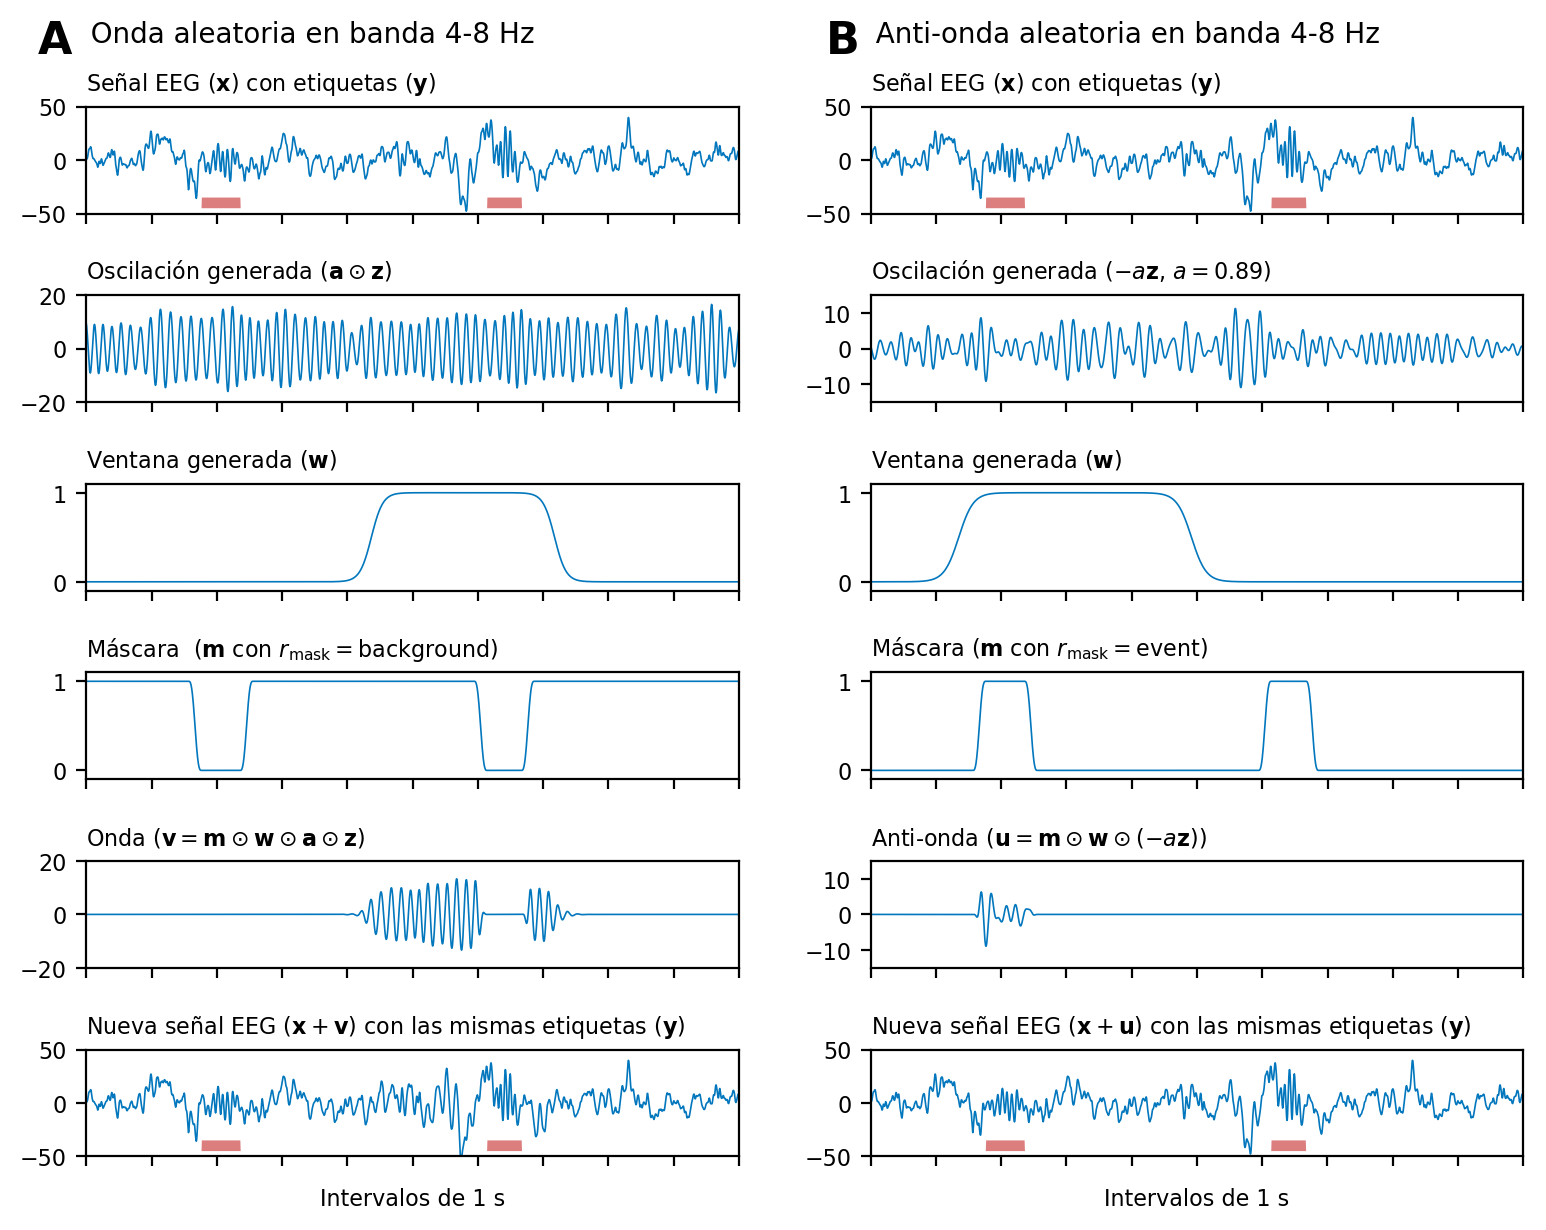

In [164]:
# Both plots
plot_args = dict(linewidth=0.6, color=viz.PALETTE['blue'])
time_axis = np.arange(feat.size) / fs
fig, axess = plt.subplots(6, 2, figsize=(8, 6), sharex=True, dpi=200)
plot_wave_in_axes(axess[:, 0])
plot_antiwave_in_axes(axess[:, 1])
plt.tight_layout()
axess[0, 0].text(
    x=-0.02, y=1.5, fontsize=16, 
    s=r"$\bf{A}$", 
    ha="right", transform=axess[0, 0].transAxes)
axess[0, 0].text(
    x=-0.02, y=1.6, fontsize=10, 
    s="  Onda aleatoria en banda 4-8 Hz", 
    ha="left", transform=axess[0, 0].transAxes)
axess[0, 1].text(
    x=-0.02, y=1.5, fontsize=16, 
    s=r"$\bf{B}$", 
    ha="right", transform=axess[0, 1].transAxes)
axess[0, 1].text(
    x=-0.02, y=1.6, fontsize=10, 
    s="  Anti-onda aleatoria en banda 4-8 Hz", 
    ha="left", transform=axess[0, 1].transAxes)

plt.savefig("ejemplo_onda_antionda.pdf", bbox_inches="tight", pad_inches=0.5)
plt.savefig("ejemplo_onda_antionda.png", bbox_inches="tight", pad_inches=0.5)
plt.savefig("ejemplo_onda_antionda.svg", bbox_inches="tight", pad_inches=0.5)

plt.show()